In [32]:
test = pd.DataFrame(ikis_all)
print(np.std(test[0]))
print(test[0].std())

print(test)
np.std(test, axis=0)
# np.std([0.303956, 0.664067, 0.175996, 0.287914])
np.std(test[0])

0.08330338226952919
0.08835657974783895
          0         1         2         3
0  0.303956  0.664067  0.175996  0.287914
1  0.239904  0.224003  0.119992  0.392036
2  0.247990  0.208018  0.167968  0.384009
3  0.184084  0.231951  0.128006  0.231970
4  0.207929  0.335963  0.192031  0.223986
5  0.207945  0.192003  0.127981  0.160019
6  0.295967  0.159999  0.144082  0.103940
7  0.480041  0.327939  0.208018  0.287998
8  0.264033  0.135965  0.120014  0.151994


np.float64(0.08330338226952919)

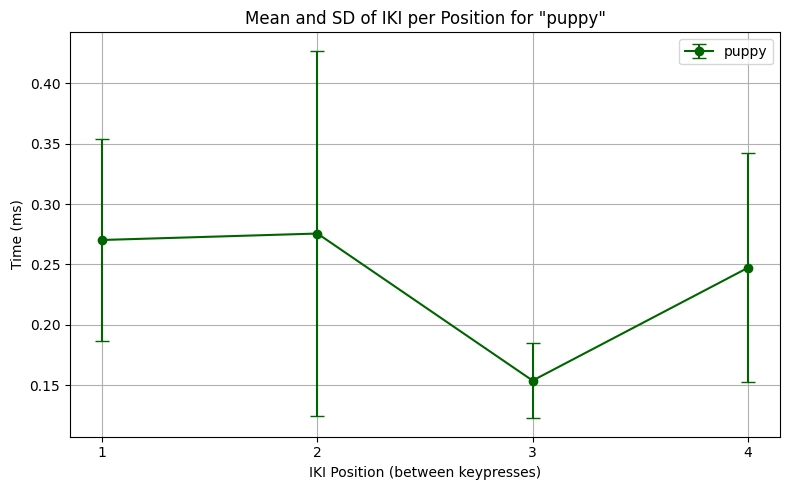

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/rubi/Desktop/s352_bytrial.csv')
df['core'] = df['resp_string'] == df['string']
df_core = df[df['core'] == True].copy()
rt_cols = [col for col in df.columns if col.startswith('key_resp.rt.')]

target_word = 'puppy'  # <- CHANGE THIS to the word I want

# Filter for that word
word_df = df_core[df_core['string'] == target_word]

# IKI values per trial
ikis_all = []

for _, row in word_df.iterrows():
    rts = row[rt_cols].values.astype(float)
    rts = rts[rts > 0]
    if len(rts) < 2:
        continue
    ikis = np.diff(rts)
    ikis_all.append(ikis)

# get stats
iki_matrix = np.vstack(ikis_all)
mean_iki = np.mean(iki_matrix, axis=0)
std_iki = np.std(iki_matrix, axis=0)
positions = np.arange(1, len(mean_iki) + 1)

# Plot the graph (Note: improve this)
plt.figure(figsize=(8, 5))
plt.errorbar(positions, mean_iki, yerr=std_iki, marker='o', capsize=5, label=target_word, color='darkgreen')

plt.title(f'Mean and SD of IKI per Position for "{target_word}"')
plt.xlabel('IKI Position (between keypresses)')
plt.ylabel('Time (ms)')
plt.xticks(positions)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

path = "/Users/rubi/Desktop/s352_bytrial.csv"
rt_cols = ['key_resp.rt.1','key_resp.rt.2','key_resp.rt.3','key_resp.rt.4','key_resp.rt.5'] ## you define rt_cols above and can keep that or if this is different pick a different variable name
ALPHA = 0.05

def detect_rt_mode(df, rt_cols, thresh=0.90):
    """Return 'cumulative' if most rows are monotonic increasing across rt_cols, else 'per_press'."""
    sub = df.dropna(subset=rt_cols).copy()
    if sub.empty:
        return "unknown"
    mono = (sub[rt_cols].diff(axis=1).ge(0).all(axis=1)).mean()
    return "cumulative" if mono > thresh else "per_press"

df = pd.read_csv(path)
df_core = df[(df['resp_string'] == df['string']) & (df['string'] == target_word)].copy()

mode = detect_rt_mode(df_core, rt_cols)

# Build IKIs for each trial 
ikis = []
for _, row in df_core.iterrows():
    rts = pd.to_numeric(row[rt_cols], errors='coerce').values
    if not np.all(np.isfinite(rts)):
        continue

    if mode == "cumulative":
        diffs = np.diff(rts) 
        if np.any(diffs < 0):
            continue
        ikis.append(diffs)
    else:
        per_press = rts[1:5]      
        if len(per_press) != 4 or np.any(per_press < 0):
            continue
        ikis.append(per_press)

if not ikis:
    print(f"No valid trials found for '{target_word}'.")
    raise SystemExit

MAT = np.vstack(ikis) 

# Wilcoxon 
rows = []
boundaries = []  
for i in range(MAT.shape[1] - 1):
    x = MAT[:, i]
    y = MAT[:, i+1]
    stat, p = wilcoxon(x, y, zero_method="pratt")
    mean_x = float(np.mean(x))
    mean_y = float(np.mean(y))

    direction = "ns"
    if p < ALPHA:
        direction = "increase" if mean_y > mean_x else "decrease"
        if direction == "increase":
            boundaries.append(i + 3) 

    rows.append({
        "Compare": f"IKI{i+1} (press {i+1}->{i+2}) vs IKI{i+2} (press {i+2}->{i+3})",
        "mean_n": round(mean_x, 3),
        "mean_next": round(mean_y, 3),
        "p_value": f"{p:.3e}",
        "direction": direction,
        "n_trials": MAT.shape[0],
    })

results_df = pd.DataFrame(rows, columns=["Compare","mean_n","mean_next","p_value","direction","n_trials"])
print(f"\nWilcoxon results on successive IKIs for '{target_word}' (all trials):")
print(results_df.to_string(index=False))

# Build chunks from boundaries
chunks = []
start = 1
for b in sorted(set(boundaries)):
    chunks.append([start, b-1])
    start = b
chunks.append([start, 5])  # close the last chunk

# Keep only chunks with length ≥ 2 (this will be something we change but keep it while you intergrate the two cells)
valid_chunks = [c for c in chunks if (c[1] - c[0] + 1) >= 2]
fmt = lambda a,b: f"{a}–{b}" if a != b else f"{a}"

print("\nInferred chunk ranges (tentative):", ", ".join(fmt(a,b) for a,b in chunks))
print("Valid chunks (length ≥ 2):", "none" if not valid_chunks else ", ".join(fmt(a,b) for a,b in valid_chunks))



Wilcoxon results on successive IKIs for 'puppy' (all trials):
                               Compare  mean_n  mean_next   p_value direction  n_trials
IKI1 (press 1->2) vs IKI2 (press 2->3)   1.011      1.286 3.906e-03  increase         9
IKI2 (press 2->3) vs IKI3 (press 3->4)   1.286      1.440 3.906e-03  increase         9
IKI3 (press 3->4) vs IKI4 (press 4->5)   1.440      1.687 3.906e-03  increase         9

Inferred chunk ranges (tentative): 1–2, 3, 4, 5
Valid chunks (length ≥ 2): 1–2
